# Training and testing with different classifiers

This notebook contains code to apply different ml models to the pre-processed recipe-ingredient dataset. For pre-processing, check the other notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import WordNetLemmatizer
import inflect

In [2]:
# Read the dataset
df = pd.read_json('dataset.json')

Loading the dataset and pre-processing based on understanding of previous EDA.
1. Converting text into lowercase
2. Removing leading and trailing whitespace
3. Removing punctuation, numbers and special characters
4. Replacing plural words with singular versions
5. Lemmatizing the words

In [3]:
wn = WordNetLemmatizer() # lemmatizing instead of stemming to preserve context
p = inflect.engine() # to change to singular instead of stemming

def format_ingredients(ingredient_list):
    formatted = [ing.strip().lower() for ing in ingredient_list]
    alpha = [(''.join(char for char in ing if char.isalpha())) for ing in formatted]
    singular = [p.singular_noun(ing) or ing for ing in alpha]
    lemmatized = [wn.lemmatize(ing) for ing in singular]
    return (', '.join(lemmatized))

df['ingredients_formatted'] = df['ingredients'].apply(lambda x: format_ingredients(x))
print(df.head(10))

      id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   
5   6602     jamaican  [plain flour, sugar, butter, eggs, fresh ginge...   
6  42779      spanish  [olive oil, salt, medium shrimp, pepper, garli...   
7   3735      italian  [sugar, pistachio nuts, white almond bark, flo...   
8  16903      mexican  [olive oil, purple onion, fresh pineapple, por...   
9  12734      italian  [chopped tomatoes, fresh basil, garlic, extra-...   

                               ingredients_formatted  
0  romainelettuce, blackolife, grapetomato, garli...  
1  plainflour, groundpepper, salt, tomato, ground... 

### Vectorizing

The ingredient list is already tokenized (as an array of ingredients), but needs to be vectorized (i.e. encoded so as to be able to create feature vectors for the machine learning algorithms to train/test)

Apply TF-IDF vectorization on the dataset, and transform it to a dense matrix.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', analyzer='word', max_df=0.8, token_pattern=r'\w+')
x_tfidf = tfidf.fit_transform(df['ingredients_formatted'])
print(x_tfidf.shape)

(39774, 6636)


K-means with the real number of 'neigbours' (20 - types of cuisines in the dataset)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df['cuisine'], random_state=42)

# clf = KNeighborsClassifier()
# clf.fit(x_train, y_train)
# print(f'Training >> {clf.score(x_train, y_train)}') #74.35
# print(f'Testing >> {clf.score(x_test, y_test)}') #60.8
scores = []
for i in range(5,25,5): # 5 to 25 in steps of 5 
    clf = KNeighborsClassifier(i)
    clf.fit(x_train, y_train)
    scores.append([i, clf.score(x_train, y_train), clf.score(x_test, y_test)])

score_df = pd.DataFrame(scores, columns=['K', 'Training', 'Testing'])
print(score_df)

    K  Training   Testing
0   5  0.746463  0.609312
1  10  0.737546  0.659393
2  15  0.731948  0.675583
3  20  0.728294  0.680209


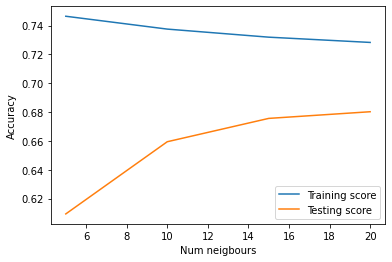

In [23]:
plt.plot(range(5,25,5), score_df['Training'], label='Training score')
plt.plot(range(5,25,5), score_df['Testing'], label='Testing score')
plt.ylabel('Accuracy')
plt.xlabel('Num neigbours')
plt.legend()
plt.savefig('graphs_and_vis/KNN_choosing_k.png')

In [11]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [14]:
models = [
    ('KNN', KNeighborsClassifier(n_neighbors=20)),
    ('LogisticRegression', LogisticRegression()),
    ('NaiveBayes', MultinomialNB()),
    ('DecisionTree', tree.DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier(min_samples_split=5)),
    ('SVM', SVC())
]

results = []
for name, model in models:
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    results.append((name, cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')))

print(results)




/Users/sunellauni/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sunellauni/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[('KNN', array([0.67699115, 0.67524892, 0.66770592])), ('LogisticRegression', array([0.63012872, 0.61198833, 0.61047973])), ('NaiveBayes', array([0.47264682, 0.46605652, 0.44523786])), ('DecisionTree', array([0.56928801, 0.56854068, 0.56270743])), ('RandomForest', array([0.66039823, 0.6505079 , 0.64135573])), ('SVM', array([0.59422767, 0.57678769, 0.5677361 ]))]


In [17]:
print(x_train.shape)

(29830, 787775)


In [18]:
clf= KNeighborsClassifier(171) 
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.6711029165269863
0.6682421560740145


In [19]:
clf= KNeighborsClassifier(172) 
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.6711364398256788
0.668543845534996
